In [1]:
!apt install libomp-dev
!pip install faiss

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libomp5
Suggested packages:
  libomp-doc
The following NEW packages will be installed:
  libomp-dev libomp5
0 upgraded, 2 newly installed, 0 to remove and 30 not upgraded.
Need to get 239 kB of archives.
After this operation, 804 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp5 amd64 5.0.1-1 [234 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp-dev amd64 5.0.1-1 [5,088 B]
Fetched 239 kB in 1s (410 kB/s)
Selecting previously unselected package libomp5:amd64.
(Reading database ... 160980 files and directories currently installed.)
Preparing to unpack .../libomp5_5.0.1-1_amd64.deb ...
Unpacking libomp5:amd64 (5.0.1-1) ...
Selecting previously unselected package libomp-dev.
Preparing to unpack .../libomp-dev_5.0.1-1_amd64.deb ...
Unpacking libomp-dev (5.0.1-

In [2]:
import faiss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import struct
import time
import random

from tqdm.auto import tqdm

from typing import List, Dict, Tuple, Set, Sequence, Any, Union, Optional

In [3]:
SIFT_DOWNLOAD_PATH = 'ftp://ftp.irisa.fr/local/texmex/corpus/sift.tar.gz'
GIST_DOWNLOAD_PATH = 'ftp://ftp.irisa.fr/local/texmex/corpus/gist.tar.gz'

In [4]:
!wget $SIFT_DOWNLOAD_PATH
!wget $GIST_DOWNLOAD_PATH

--2021-04-07 18:05:50--  ftp://ftp.irisa.fr/local/texmex/corpus/sift.tar.gz
           => ‘sift.tar.gz’
Resolving ftp.irisa.fr (ftp.irisa.fr)... 131.254.254.45, 2001:660:7303:254::45
Connecting to ftp.irisa.fr (ftp.irisa.fr)|131.254.254.45|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /local/texmex/corpus ... done.
==> SIZE sift.tar.gz ... 168280445
==> PASV ... done.    ==> RETR sift.tar.gz ... done.
Length: 168280445 (160M) (unauthoritative)

sift.tar.gz         100%[===================>] 160.48M  32.0MB/s    in 5.6s    

2021-04-07 18:05:57 (28.9 MB/s) - ‘sift.tar.gz’ saved [168280445]

--2021-04-07 18:05:57--  ftp://ftp.irisa.fr/local/texmex/corpus/gist.tar.gz
           => ‘gist.tar.gz’
Resolving ftp.irisa.fr (ftp.irisa.fr)... 131.254.254.45, 2001:660:7303:254::45
Connecting to ftp.irisa.fr (ftp.irisa.fr)|131.254.254.45|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.   

In [5]:
!tar -xf sift.tar.gz && rm sift.tar.gz
!tar -xf gist.tar.gz && rm gist.tar.gz

In [6]:
def ivecs_read(fname):
    a = np.fromfile(fname, dtype=np.int32)
    d = a[0]
    return a.reshape(-1, d + 1)[:, 1:].copy()

def fvecs_read(fname):
    return ivecs_read(fname).view(np.float32)



In [7]:
def recall(y_pred, y_true, top_k=None):

    def isin1d(x):
        x, y = np.split(x, 2)
        return np.isin(x, y, assume_unique=True)

    if top_k is None or top_k > y_pred.shape[1]:
        top_k = y_pred.shape[1]
    return np.sum(np.apply_along_axis(isin1d, 1, 
                  np.concatenate((y_pred[:, :top_k], y_true[:, :top_k]), 
                                 axis=1))) / (len(y_pred) * top_k)


# FAISS TESTING

In [8]:
!cat /proc/cpuinfo 
!cat /proc/meminfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2200.152
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4400.30
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

#### Constants


In [9]:
SAMPLE_RATE = 0.01
N_CLUSTERS = 100
MAX_TOP_K = 100


### Helper Functions

In [10]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)

seed_everything(42)

In [11]:
def sample_learn(base: np.ndarray, sample_rate=SAMPLE_RATE):
    learning_len = int(base.shape[0] * SAMPLE_RATE)    
    ln_indexes = np.random.choice(base.shape[0], learning_len, replace=False)
    return base[ln_indexes, :]

In [32]:
def train(learn, base, n_clusters):
    """
    base: base queries from SiFT/GiST dataset
    n_clusters: number of clusters for kMeans 
    """
    D = base.shape[1]
    quantizer = faiss.IndexFlatL2(D)
    index = faiss.IndexIVFFlat(quantizer, D, n_clusters, faiss.METRIC_L2)
    assert not index.is_trained
    build_start = time.time() 
    index.train(learn)
    assert index.is_trained
    index.add(base)
    build_end = time.time()
    return (index, build_end - build_start)


In [13]:
def search(index, query, gt, top_k=MAX_TOP_K, n_probe=1):
    """
    index: trained IVFFlat Index
    query: query for nearest neighbour search 
    gt: ground-truth answers for NNS
    top_k: top_k for correct search working
    n_probe: number of chosen clusters 
    """
    assert index.is_trained
    NQ = query.shape[0]
    index.nprobe = n_probe
    s_start = time.time()
    distances, indexes = index.search(query, top_k)
    s_end = time.time()
    rec = recall(indexes, gt, top_k)
    return (rec, (s_end - s_start) * 1000.0 / NQ)

In [25]:
def get_and_save_stats(n_probes: List[int],
                        n_clusters: List[int],
                        base: np.ndarray,
                        learn: np.ndarray,
                        query: np.ndarray,
                        ground_truth: np.ndarray,
                        filename_prefix: str):
    df_s = []
    for n_cl in n_clusters:
        df = pd.DataFrame({'n_probes': [], 'build_time, s': None, 
                       'query_time, ms': [], 'R@1': [], 'R@100': []})
        index, build_time = train(learn=learn, base=base, n_clusters=n_cl)
        for probe in tqdm(n_probes):
            rec_1, s_1_t = search(index, query, ground_truth, 
                                  top_k=1, n_probe=probe)
            rec_100, s_100_t = search(index, query, ground_truth, 
                                      top_k=100, n_probe=probe)
            row = pd.Series({'n_probes': probe, 'build_time': build_time, 
                         'query_time, ms': s_100_t, 'R@1': rec_1, 'R@100': rec_100})
            df = df.append(row, ignore_index=True)
        filename = f'{filename_prefix}_cc_{n_cl}.csv'
        df.to_csv(filename)
        df_s.append(df)
    return df_s


# SIFT

In [15]:
sift_base = fvecs_read('./sift/sift_base.fvecs')
sift_gt = ivecs_read('./sift/sift_groundtruth.ivecs')
sift_learn = fvecs_read('./sift/sift_learn.fvecs')
sift_query = fvecs_read('./sift/sift_query.fvecs')

In [16]:
sift_learn = sample_learn(sift_base)
sift_learn.shape

(10000, 128)

In [17]:
SIFT_N_PROBES = [1, 2, 3, 4, 5, 7, 10, 15, 20, 30]
SIFT_N_CLUSTERS = [100, 200]
SIFT_PREFIX = 'sift'

In [26]:
sift_stats = get_and_save_stats(SIFT_N_PROBES, 
                                SIFT_N_CLUSTERS, 
                                sift_base, 
                                sift_learn, 
                                sift_query, 
                                sift_gt, 
                                SIFT_PREFIX)

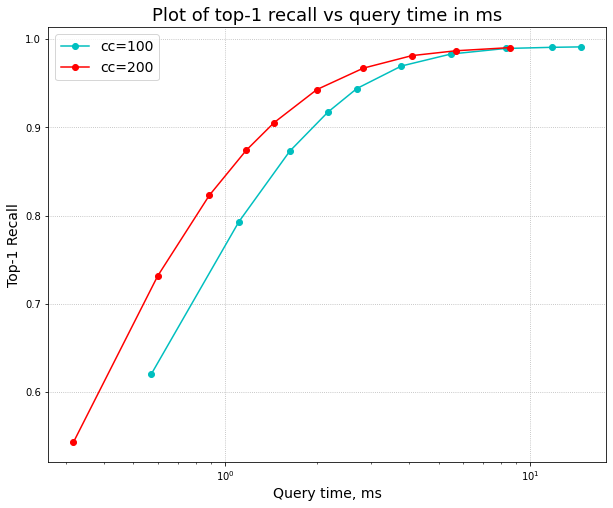

In [50]:
def visualize_sift():
    s_100 = pd.read_csv('./sift_cc_100.csv')
    s_200 = pd.read_csv('./sift_cc_200.csv')
    plt.figure(figsize=(10, 8))

    plt.plot(s_100['query_time, ms'], s_100['R@1'], 'o-c',  label='cc=100')
    plt.plot(s_200['query_time, ms'], s_200['R@1'], 'o-r', label='cc=200')
    plt.xscale('log')
    plt.title('Plot of top-1 recall vs query time in ms', fontsize=18)
    plt.legend(fontsize=14)
    plt.xlabel('Query time, ms', fontsize=14)
    plt.ylabel('Top-1 Recall', fontsize=14)
    plt.grid(ls=':')

visualize_sift()

# GIST

In [27]:
gist_base = fvecs_read('./gist/gist_base.fvecs')
gist_gt = ivecs_read('./gist/gist_groundtruth.ivecs')
gist_learn = fvecs_read('./gist/gist_learn.fvecs')
gist_query = fvecs_read('./gist/gist_query.fvecs')

In [28]:
gist_learn = sample_learn(gist_base)
gist_learn.shape

(10000, 960)

In [29]:
GIST_N_PROBES = [1, 2, 3, 4, 5, 7, 10, 15, 20, 30]
GIST_N_CLUSTERS = [100, 200]
GIST_PREFIX = 'gist'

In [33]:
gist_stats = get_and_save_stats(GIST_N_PROBES, 
                                GIST_N_CLUSTERS, 
                                gist_base, 
                                gist_learn, 
                                gist_query, 
                                gist_gt, 
                                GIST_PREFIX)

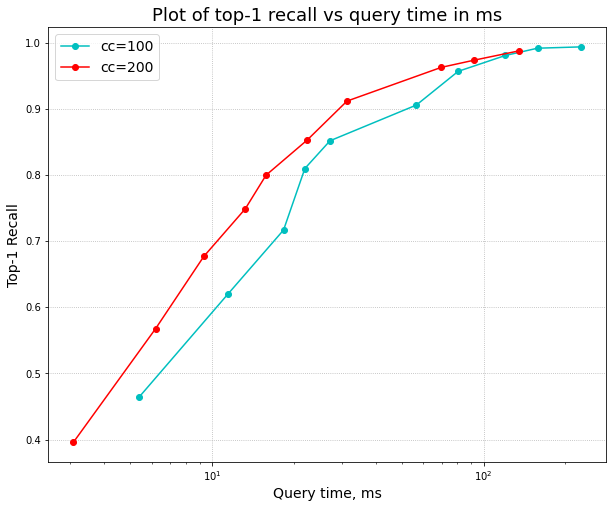

In [53]:
def visualize_gift():
    g_100 = pd.read_csv('./gist_cc_100.csv')
    g_200 = pd.read_csv('./gist_cc_200.csv')
    plt.figure(figsize=(10, 8))

    plt.plot(g_100['query_time, ms'], g_100['R@1'], 'o-c',  label='cc=100')
    plt.plot(g_200['query_time, ms'], g_200['R@1'], 'o-r', label='cc=200')
    plt.xscale('log')
    plt.title('Plot of top-1 recall vs query time in ms', fontsize=18)
    plt.legend(fontsize=14)
    plt.xlabel('Query time, ms', fontsize=14)
    plt.ylabel('Top-1 Recall', fontsize=14)
    plt.grid(ls=':')

visualize_gift()